## 1. Giới thiệu
CIFAR-10 gồm 50,000 ảnh train (32×32 RGB).  
Mỗi file `.bin` chứa:
- 1 byte label  
- 3072 byte ảnh (RGB)  

Mục tiêu EDA: xem phân phối class, cấu trúc ảnh, thống kê pixel, và độ khó dữ liệu.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2

## 2. Load dữ liệu CIFAR-10
Chúng ta viết hàm tải file `.bin` và load toàn bộ 5 batch train.


In [15]:
DATA_DIR = './cifar-10-batches-bin'
BATCH_FILES = [
    'data_batch_1.bin','data_batch_2.bin',
    'data_batch_3.bin','data_batch_4.bin','data_batch_5.bin'
]

def load_batch(path):
    raw = np.fromfile(path, dtype=np.uint8).reshape(-1, 3073)
    labels = raw[:, 0]
    images = raw[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

images, labels = [], []
for f in BATCH_FILES:
    img, lab = load_batch(os.path.join(DATA_DIR, f))
    images.append(img)
    labels.append(lab)

images = np.concatenate(images)
labels = np.concatenate(labels)

images.shape, labels.shape


((50000, 32, 32, 3), (50000,))

## 3. Ảnh mẫu
Kiểm tra dữ liệu để thấy đặc trưng: nhỏ, nhiều nhiễu nền, màu sắc đa dạng.


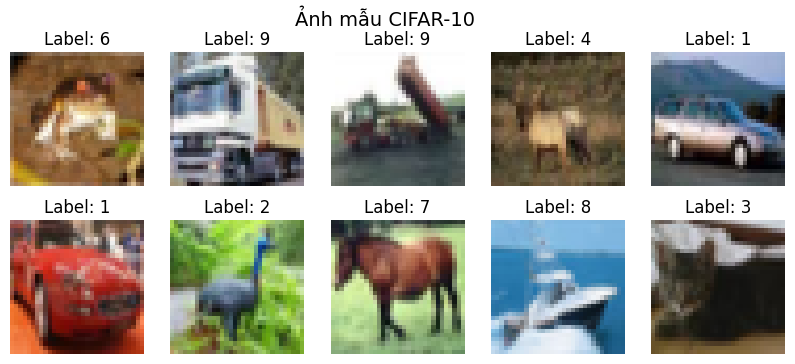

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")
plt.suptitle("Ảnh mẫu CIFAR-10", fontsize=14)
plt.show()


## 4. Phân phối label
Dataset cân bằng hoàn toàn: mỗi class ~5000 ảnh.


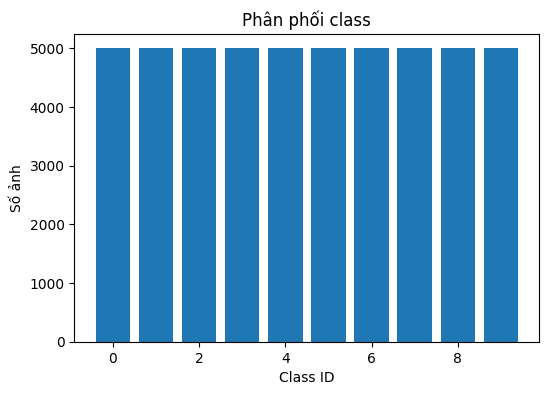

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

In [17]:
counts = np.bincount(labels, minlength=10)

plt.figure(figsize=(6,4))
plt.bar(range(10), counts)
plt.title("Phân phối class")
plt.xlabel("Class ID")
plt.ylabel("Số ảnh")
plt.show()
counts


## 5. Thống kê pixel
- Ảnh đã khá đều, không có outlier lớn.  
- Các kênh màu phân bố khá đều


In [18]:
mean = images.mean(axis=(0,1,2)) / 255
std  = images.std(axis=(0,1,2)) / 255
mean, std


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

## 6. Ảnh trung bình của dataset
Ảnh trung bình bị mờ → chứng tỏ dataset rất đa dạng tư thế, màu, góc nhìn.


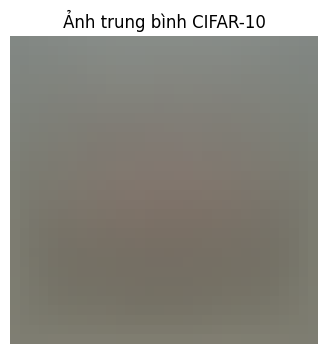

In [19]:
mean_img = images.mean(axis=0).astype(np.uint8)

plt.figure(figsize=(4,4))
plt.imshow(mean_img)
plt.title("Ảnh trung bình CIFAR-10")
plt.axis("off")
plt.show()


## Kết luận EDA

- CIFAR-10 cân bằng, không lệch class.
- Ảnh nhỏ 32×32 → chứa ít thông tin, nhiều nhiễu → mô hình cần mạnh (CNN).
- Mean/Std RGB ổn → dễ chuẩn hóa khi train.
- PCA không phân tách tốt → dữ liệu khó tuyến tính.
- t-SNE cho thấy một số lớp rõ ràng, nhưng cat/dog, auto/truck chồng lẫn.
- Ảnh trung bình cho thấy độ đa dạng cao → cần augmentation (random crop, flip).

=> Tổng quan: CIFAR-10 là dataset mức trung bình–khó, thích hợp để thử nghiệm CNN, ResNet, EfficientNet.


## 7. Tiền xử lý & Lưu dữ liệu dạng .bin (Preprocess & Save)
Bước này thực hiện:
1. Áp dụng Unsharp Mask (làm nét) và Normalize (chuẩn hóa).
2. Chuyển đổi sang `float32` (do đã chuẩn hóa).
3. Chia thành 5 file `data_batch_*.bin` (Train) và 1 file `test_batch.bin` (Valid).
4. Lưu xuống ổ cứng để cache.

In [20]:
import os
import torch
import numpy as np
from PIL import Image, ImageFilter
from torchvision import transforms
# --- SỬA LỖI: Dùng tqdm bản thường, không dùng bản notebook ---
from tqdm import tqdm 

# --- CẤU HÌNH ---
PROCESSED_BIN_DIR = './data/cifar-10-processed-bin' 
if not os.path.exists(PROCESSED_BIN_DIR):
    os.makedirs(PROCESSED_BIN_DIR)

STATS = ((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
VAL_SIZE = 5000 

# Transform tĩnh (Làm nét + Chuẩn hóa)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=1, percent=150, threshold=3))),
    transforms.ToTensor(),
    transforms.Normalize(*STATS)
])

def save_as_cifar_batches(images_np, labels_np):
    print("🚀 Đang xử lý ảnh (Unsharp + Normalize)...")
    
    # 1. Xử lý ảnh và đưa về dạng phẳng (N, 3073) [Label, px1, px2...]
    data_list = []
    for i in tqdm(range(len(images_np)), desc="Processing"):
        # Preprocess -> Tensor (3, 32, 32) -> Flatten (3072,)
        flat_img = preprocess(images_np[i]).numpy().flatten()
        # Gắn nhãn vào đầu
        row = np.concatenate(([float(labels_np[i])], flat_img))
        data_list.append(row)
        
    full_data = np.array(data_list, dtype=np.float32)
    
    # 2. Shuffle và Tách Train/Val
    np.random.shuffle(full_data)
    val_data = full_data[:VAL_SIZE]
    train_data = full_data[VAL_SIZE:]
    
    print(f"📦 Train: {len(train_data)} | Val: {len(val_data)}")
    
    # 3. Chia nhỏ Train thành 5 batch và Lưu
    num_batches = 5
    batch_size = len(train_data) // num_batches
    
    print(f"💾 Đang lưu xuống {PROCESSED_BIN_DIR}...")
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size if i < num_batches - 1 else len(train_data)
        
        fname = os.path.join(PROCESSED_BIN_DIR, f'data_batch_{i+1}.bin')
        train_data[start:end].tofile(fname)
        print(f"   -> Saved: {fname}")
        
    # Lưu Val
    val_fname = os.path.join(PROCESSED_BIN_DIR, 'test_batch.bin')
    val_data.tofile(val_fname)
    print(f"   -> Saved Valid: {val_fname}")
    print("✅ Hoàn tất!")

# Thực thi (Input là biến images, labels từ phần EDA)
save_as_cifar_batches(images, labels)

🚀 Đang xử lý ảnh (Unsharp + Normalize)...











































































































































































































































































Processing: 100%|██████████| 50000/50000 [00:29<00:00, 1681.69it/s]


📦 Train: 45000 | Val: 5000
💾 Đang lưu xuống ./data/cifar-10-processed-bin...
   -> Saved: ./data/cifar-10-processed-bin\data_batch_1.bin
   -> Saved: ./data/cifar-10-processed-bin\data_batch_2.bin
   -> Saved: ./data/cifar-10-processed-bin\data_batch_3.bin
   -> Saved: ./data/cifar-10-processed-bin\data_batch_4.bin
   -> Saved: ./data/cifar-10-processed-bin\data_batch_5.bin
   -> Saved Valid: ./data/cifar-10-processed-bin\test_batch.bin
✅ Hoàn tất!


## 8. Xây dựng Dataset Class & Kiểm tra
Tạo class `PreprocessedBinDataset` để đọc các file `.bin` (dạng float32) vừa tạo.

In [21]:
from torch.utils.data import Dataset, DataLoader

class PreprocessedBinDataset(Dataset):
    def __init__(self, bin_files, augment=False):
        self.images, self.labels = [], []
        self.augment = augment
        
        # Augmentation (Chỉ dùng cho Train)
        self.aug_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.RandomHorizontalFlip(p=0.5),
        ])

        # Load các file .bin
        for file_path in bin_files:
            # Đọc float32 (quan trọng)
            data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 3073)
            self.labels.append(data[:, 0].astype(np.int64))
            self.images.append(data[:, 1:].reshape(-1, 3, 32, 32)) # Reshape lại thành ảnh
            
        self.images = np.concatenate(self.images)
        self.labels = np.concatenate(self.labels)

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        # Convert numpy -> tensor
        img = torch.tensor(self.images[idx], dtype=torch.float32)
        label = self.labels[idx]
        
        if self.augment:
            img = self.aug_transform(img)
        return img, label

# --- KIỂM TRA LOAD DỮ LIỆU ---
train_files = [os.path.join(PROCESSED_BIN_DIR, f'data_batch_{i}.bin') for i in range(1, 6)]
val_files = [os.path.join(PROCESSED_BIN_DIR, 'test_batch.bin')]

# Tạo DataLoader
train_loader = DataLoader(PreprocessedBinDataset(train_files, augment=True), batch_size=64, shuffle=True)
val_loader = DataLoader(PreprocessedBinDataset(val_files, augment=False), batch_size=64, shuffle=False)

# Test 1 batch
xb, yb = next(iter(train_loader))
print(f"Load thành công! Batch shape: {xb.shape} | Label shape: {yb.shape}")

Load thành công! Batch shape: torch.Size([64, 3, 32, 32]) | Label shape: torch.Size([64])
